In [1]:
import numpy as np
import random
import traci
import matplotlib.pyplot as plt
import pickle

from helper_functions import get_nearest_vehicle_distance, update_live_plot

# Parameters

In [2]:
# SUMO configuration
SUMO_BINARY = "sumo"    # or "sumo-gui"
SUMO_CONFIG = "../config/my_simulation.sumocfg"

# Hyperparameters
GAMMA = 1  # Discount factor
ALPHA = 0.1  # Learning rate
EPSILON = 0.1  # Exploration rate

NBR_EPISODES = 100
STEPS_PER_EPISODE = 1000

# Environment parameters
STATE_SIZE = 6
ACTION_SIZE = 2

# State discretezation & normalization parameters
STATE_BINS = [10, 10, 10, 2, 2, 10]
feature_min = [0, 0, 0, 0, 0, 10]  # Min values for each state feature
feature_max = [10, 15, 18, 1, 1, 150]  # Max values for each state feature

# Initialize Q-table
q_table = np.zeros(STATE_BINS + [ACTION_SIZE])

# MDP

### State Space

In [3]:

# Helper functions
def discretize_state(state):
    """Discretize the continuous state into discrete bins."""
    state_bins = []
    for i, feature in enumerate(state):
        bin_index = int((feature - feature_min[i]) / (feature_max[i] - feature_min[i]) * (STATE_BINS[i] - 1))
        state_bins.append(np.clip(bin_index, 0, STATE_BINS[i] - 1))

    # print(tuple(state_bins))
    return tuple(state_bins)


In [4]:
def get_state():
    """Retrieve the current state from SUMO"""

    # Cars density
    highway_density = traci.edge.getLastStepVehicleNumber("E6")

    # Cars speed
    highway_speed = traci.edge.getLastStepMeanSpeed("E6")
    ramp_speed = traci.edge.getLastStepMeanSpeed("E8")
    
    # Halting cars
    highway_halts = traci.edge.getLastStepHaltingNumber("E6")
    ramp_halts = traci.edge.getLastStepHaltingNumber("E8")

    # Nearest Distance from highway to TL
    nearest_distance_highway = get_nearest_vehicle_distance("J11", "E6")


    state = [
        highway_density,
        highway_speed,
        ramp_speed,
        highway_halts,
        ramp_halts,
        nearest_distance_highway
    ]
    
    return state


### Reward Function

In [5]:
def calculate_reward(state):
    """Calculate reward based on the current state"""

    highway_speed = state[1]
    ramp_speed = state[2]
    highway_halts = state[3]
    ramp_halts = state[4]

    # ramp_density = traci.edge.getLastStepVehicleNumber("E8")
    nbr_stopping_vehicles = traci.simulation.getEmergencyStoppingVehiclesNumber()       # Emergency stopping cars
    nbr_colliding_vehicles = traci.simulation.getCollidingVehiclesNumber()              # Collisions (accidents)

    reward = - (highway_halts + ramp_halts + nbr_stopping_vehicles) + (highway_speed + ramp_speed) * 0.1 - nbr_colliding_vehicles * 10
    
    return reward

### Action Space

In [6]:
def choose_action(state, epsilon):
    """Epsilon-greedy action selection"""
    if random.uniform(0, 1) < epsilon:
        return random.randint(0, ACTION_SIZE - 1)  # Exploration
    return np.argmax(q_table[state])  # Exploitation


def take_action(action):
    """Apply the selected action in SUMO"""
    traci.trafficlight.setPhase("J11", action)

# Q-Learning

In [7]:
def update_q_table(state, action, reward, next_state, done):
    """Update Q-value using the Q-learning formula"""
    best_next_action = np.argmax(q_table[next_state])
    q_table[state][action] += ALPHA * (reward + GAMMA * q_table[next_state][best_next_action] - q_table[state][action])
    

# QL Train

In [8]:
episode_rewards = []


def train_ql(n_episodes = NBR_EPISODES, steps_per_episode = STEPS_PER_EPISODE, epsilon = EPSILON):
    """
    Train a Q-learning agent and return the greedy policy.

    Returns:
        np.ndarray: Greedy policy derived from the trained Q-table.
    """

    # Initialize live plots for rewards
    plt.ion()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title("Episode Rewards")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    reward_line, = ax.plot([], [], label="Reward", color="blue")
    ax.legend()

    # Start SUMO simulation
    traci.start([SUMO_BINARY, "-c", SUMO_CONFIG])

    try:
        for episode in range(n_episodes):
            state = discretize_state(get_state())
            total_reward = 0

            for step in range(steps_per_episode):
                # Select and apply action in SUMO
                action = choose_action(state, epsilon)
                take_action(action)
                traci.simulationStep()

                # Observe new state and reward
                next_state = discretize_state(get_state())
                reward = calculate_reward(next_state)
                done = (step == steps_per_episode - 1)

                # Updates
                update_q_table(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

            episode_rewards.append(total_reward)

            # Update live plot
            update_live_plot(fig, ax, reward_line, episode_rewards)
            print(f"Episode {episode + 1}: Total Reward = {total_reward}")
            
    finally:
        traci.close()

        # Finalize the plot
        plt.ioff()
        plt.show()

        policy = np.argmax(q_table, axis=1)
        return policy


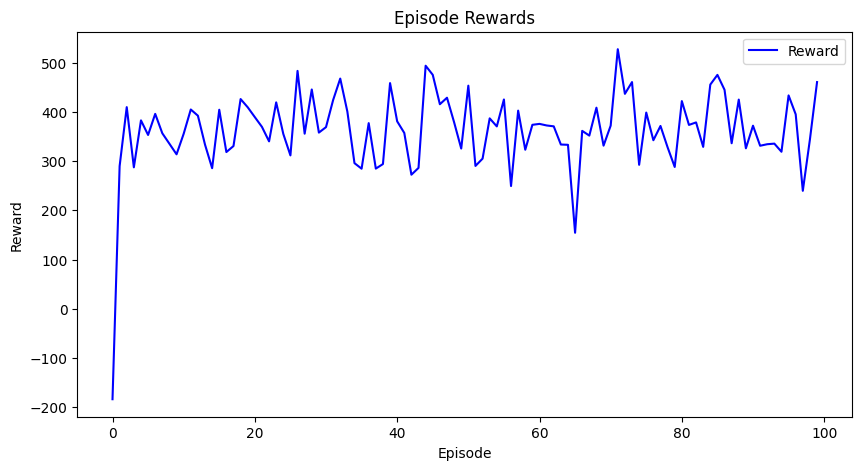

Episode 100: Total Reward = 460.5000000000005


In [9]:
ql_policy = train_ql()

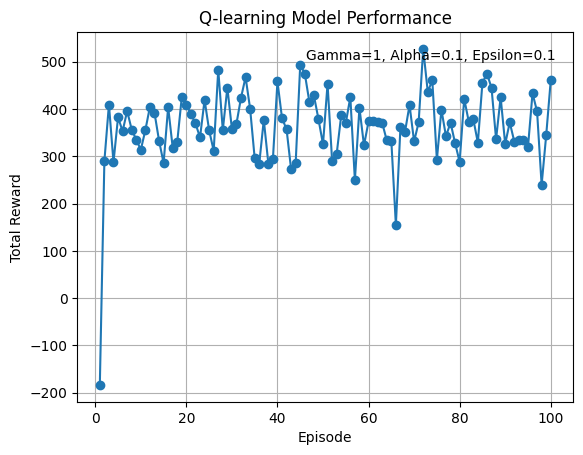

In [10]:
# Plot the episode rewards
plt.plot(range(1, NBR_EPISODES + 1), episode_rewards, marker='o')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning Model Performance')
plt.grid(True)

hyperparams_text = f'Gamma={GAMMA}, Alpha={ALPHA}, Epsilon={EPSILON}'
plt.text(NBR_EPISODES + 1, max(episode_rewards), hyperparams_text, ha='right', va='top', fontsize=10)

plt.show()

# Save the Q-learning model

In [11]:
# with open("saved_models/ql_model.pkl", "wb") as f:
#     pickle.dump(q_table, f)
